In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
class SimpleAutoEncoder(nn.Module):
  def __init__(self, feature_size=2):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 2, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True)
    )

    self.encoder_fc = nn.Linear(7*7*64, feature_size)
    self.decoder_fc = nn.Linear(feature_size, 7*7*64)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64, 64, 3, 2, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(32, 1, 3, 1, 1),
        nn.Sigmoid()
    )

  def encode(self, x):
    x = self.encoder(x)
    x = torch.flatten(x, 1)
    x = self.encoder_fc(x)
    return x
  
  def decode(self, x):
    x = self.decoder_fc(x)
    x = x.view(-1, 64, 7, 7)
    x = self.decoder(x)
    return x

  def forward(self, x):
    z = self.encode(x)
    x_pred = self.decode(z)
    return x_pred

In [9]:
mode = "train" # train or evaluate
feature_size = 2
lr = 0.0005
batch_size = 64
nrof_epochs = 30
loss_fn_name = "rmse"
device = "cuda"
model_path = "./drive/My Drive/model.pt"
transformations = transforms.Compose([
  transforms.ToTensor()
])

In [10]:
train_dataset = MNIST(
    root="./",
    train=True,
    transform=transformations,
    download=True
)

test_dataset = MNIST(
    root="./",
    train=False,
    transform=transformations,
    download=True
)

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=16,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=16,
    drop_last=True
)

In [12]:
model = SimpleAutoEncoder(feature_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheculer = None
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [15, 25, 28])

loss_fn = {
    "mse": nn.MSELoss(),
    "rmse": nn.MSELoss(),
    "cross-entropy": nn.CrossEntropyLoss()
}[loss_fn_name]

min_loss = 10e6

In [13]:
if Path(model_path).exists() and mode != "train":
  model.load_state_dict(torch.load(model_path))
else:
  model.train()
  for epoch in range(nrof_epochs):
    loss = 0.
    for i_batch, (x, _) in enumerate(train_loader):
      optimizer.zero_grad()

      x = x.to(device)
      x_pred = model(x)
      
      loss_batch = loss_fn(x_pred, x)
      if loss_fn_name == "rmse":
        loss_batch = torch.sqrt(loss_batch)
      loss_batch.backward()
      optimizer.step()

      loss += loss_batch
      # if i_batch % 20 == 0:
      #   print(f"Batch {i_batch}/{len(train_loader)} | Loss {loss.item()/(i_batch+1)}")
    # scheduler.step()
    loss = loss / (i_batch + 1)
    print(f"Epoch {epoch+1}/{nrof_epochs} | Loss {loss.item()}")

    if loss < min_loss:
      min_loss = loss
      torch.save(model.state_dict(), "./model.pt")

Epoch 1/30 | Loss 0.2321254312992096
Epoch 2/30 | Loss 0.210177943110466
Epoch 3/30 | Loss 0.20485268533229828
Epoch 4/30 | Loss 0.20196448266506195
Epoch 5/30 | Loss 0.19996221363544464
Epoch 6/30 | Loss 0.1984199732542038
Epoch 7/30 | Loss 0.19712799787521362
Epoch 8/30 | Loss 0.19601304829120636
Epoch 9/30 | Loss 0.19509564340114594
Epoch 10/30 | Loss 0.1944437026977539
Epoch 11/30 | Loss 0.19379130005836487
Epoch 12/30 | Loss 0.19314774870872498
Epoch 13/30 | Loss 0.19263994693756104
Epoch 14/30 | Loss 0.19208088517189026
Epoch 15/30 | Loss 0.19165706634521484
Epoch 16/30 | Loss 0.1912234127521515
Epoch 17/30 | Loss 0.1908346712589264
Epoch 18/30 | Loss 0.19032776355743408
Epoch 19/30 | Loss 0.19006572663784027
Epoch 20/30 | Loss 0.18969857692718506
Epoch 21/30 | Loss 0.18930689990520477
Epoch 22/30 | Loss 0.18910974264144897
Epoch 23/30 | Loss 0.18873341381549835
Epoch 24/30 | Loss 0.18850228190422058
Epoch 25/30 | Loss 0.18822260200977325
Epoch 26/30 | Loss 0.18793009221553802
Ep

In [14]:
model.eval()
loss = 0.
for i_batch, (x, _) in enumerate(test_loader):
  x = x.to(device)
  x_pred = model(x)
    
  loss_batch = loss_fn(x_pred, x)
  if loss_fn_name == "rmse":
    loss_batch = torch.sqrt(loss_batch)
  loss += loss_batch

loss = loss / (i_batch + 1)
print(f"Test set lost: {loss.item()}")

Test set lost: 0.19050413370132446


In [15]:
def rescale(x):
  x = x - np.min(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  x = x / np.max(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  return (x*255).astype(np.uint8)


def torch_to_numpy(x):
  x = x.detach().cpu().numpy()
  x = x.transpose(0, 2, 3, 1)
  x = rescale(x)
  return x
  

def make_samples_grid(x, x_pred=None, grid_shape=6*6):
  x = torch_to_numpy(x)
  if x_pred is not None:
    x_pred = torch_to_numpy(x_pred)
  
  n = 2 if x_pred is not None else 1

  H, W = x.shape[1:3]
  m = int(np.sqrt(grid_shape))
  grid = np.zeros((H*m, W*m), dtype=np.uint8)

  i = 0
  for row in range(m):
    for col in range(m):
      sample = [x, x_pred][i%n]
      grid[H*row:H*(row+1), W*col:W*(col+1)] = sample[int(i//n)][..., 0]
      i += 1
  return grid

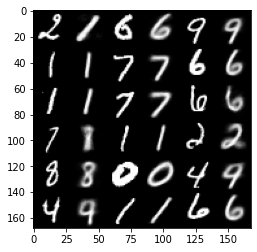

In [16]:
# Reconstruction of some of the test samples
indices = np.arange(len(test_dataset))
np.random.shuffle(indices)

x = []
y = []
for index in indices:
  image, label = test_dataset[index]
  x.append(image)
  y.append(label)

x = torch.stack(x)
x = x.to(device)
x_pred = model(x)

grid = make_samples_grid(x, x_pred)
plt.imshow(grid, cmap="gray")
plt.show()

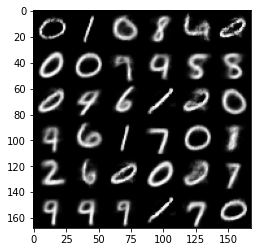

In [18]:
# Generating new samples from p_model
random = np.sqrt(10)*torch.randn((36, 2))
random = random.to(device)
random_samples = model.decode(random)

grid = make_samples_grid(random_samples)
plt.imshow(grid, cmap="gray")
plt.show()

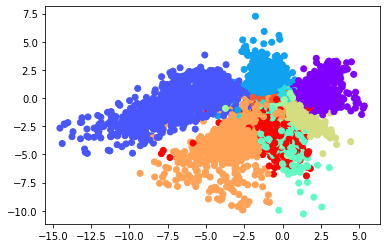

In [19]:
z = model.encode(x).detach().cpu().numpy()

x1 = z[:, 0]
x2 = z[:, 1]
colors = cm.rainbow(np.linspace(0, 1, 10))
colors = [colors[label] for label in y]

plt.scatter(x1, x2, color=colors)